In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.11:2.1.0,org.apache.kafka:kafka-clients:0.10.0-kafka-2.1.0 pyspark-shell'

In [2]:
import sys
%env SPARK_KAFKA_VERSION=0.10
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
from pyspark.sql.types import *
import pandas as pd


#Get the Afinn word repository
afinn_wl_url = ('https://raw.githubusercontent.com'
                '/fnielsen/afinn/master/afinn/data/AFINN-111.txt')
afinn_wl_df = pd.read_csv(afinn_wl_url,index_col=False,header=None,sep='\t',names=['term', 'value'])
#create dictionary out of it
sent_dict = dict(afinn_wl_df.values)

#create a function to assign sentiment value to each tweet
def add_sentiment_score(text_string):
	sum = 0
	list_of_words =  text_string.lower().split(" ")
	for i in list_of_words:
		if i in sent_dict:
			sum = sum + sent_dict.get(i)
	return sum
	
	
 
 

env: SPARK_KAFKA_VERSION=0.10


In [3]:
#start spark session
spark = SparkSession\
        .builder\
        .appName("TwitterSentimentAnalysis")\
        .getOrCreate()
            

In [4]:
#Read streamed tweets from kafka topic 
DFRaw = spark.readStream.format("kafka").option("kafka.bootstrap.servers","ip-20-0-31-221.ec2.internal:9092").option("subscribe","tweets").load()


In [5]:
#select tweet and timestamp from the read dataframe
DF = DFRaw.selectExpr("CAST(value as string) as tweet","timestamp as timestamp")


In [6]:
#Register function as spark udf
add_sentiment_score_udf = udf(add_sentiment_score,IntegerType())

#Add sentiment_score to each tweet
DF = DF.withColumn("sentiment_score",add_sentiment_score_udf(DF.tweet))

#categorize tweet as positive/negative as per sentiment score
DF = DF.select(col("*"), when(col("sentiment_score") > 0 ,"Positive").when(col("sentiment_score") < 0 ,"Negative")\
                                .otherwise("Neutral").alias("sentiment"))

In [7]:
#create a sliding window and add watermark for late data
windowedDFCounts = DF\
		.withWatermark("timestamp", "5 minutes") \
		.groupBy(
			window(DF.timestamp, "5 minutes", "2 minutes"),
			DF.sentiment) \
		.count()

In [8]:
#write Stream to memory 
query = windowedDFCounts.writeStream.outputMode("update").format("memory").queryName("twitter_stream").option("truncate","true").start()


In [9]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from time import sleep
from IPython.display import clear_output
# Create an array with the colors you want to use
colors = ["#FF0B04", "#4374B3",'#FFFFFF']
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

**********************
General Info
**********************
Run:3
Stream timestamp:2021-07-24T14:51:16.131Z
Watermark:2021-07-24T14:46:09.763Z
Total Rows:9
Updated Rows:4


/usr/local/anaconda/python2/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


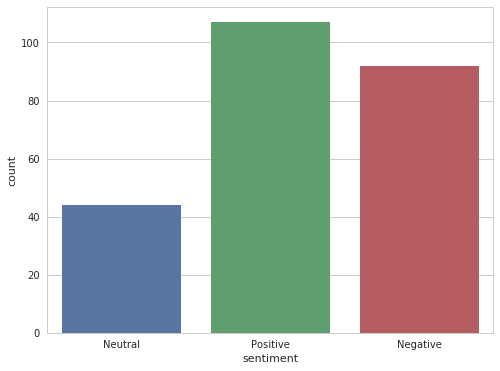

In [ ]:
matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(query.recentProgress) > 0):
            print("Stream timestamp:{}".format(query.lastProgress["timestamp"]))
            print("Watermark:{}".format(query.lastProgress["eventTime"]["watermark"]))
            print("Total Rows:{}".format(query.lastProgress["stateOperators"][0]["numRowsTotal"]))
            print("Updated Rows:{}".format(query.lastProgress["stateOperators"][0]["numRowsUpdated"]))
            
        df = spark.sql(
                """
                    select
                        window.start,window.end,sentiment,sum(count) count
                    from
                        twitter_stream
                    where
                        window.start = (select max(window.start) from twitter_stream)
                    group by
                        window.start
                        ,window.end
                        ,sentiment
                """
        ).toPandas()

        # Plot the total count
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(8,6))

        try:
            # Barplot
            sns.barplot(x="sentiment", y="count", data=df)
            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass  
        
        sleep(120)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")

